### Poisson Model to Predict Match Outcomes

The aim of the project to build a web app that predicts football match results of 2023/24 season using poisson distribution model. 

The web app is a Streamlit dashboard that can be used to analyze English Premier League Results using Poisson distribution model

### Import Packages

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import poisson
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns 
import matplotlib.pyplot as plt 
import streamlit as st

###  Webscrapping Football Data 

The dataset is a live English Premier league standings, fixtures and scores table. For this project dataset was scraped from [Fbref.](https://fbref.com/en/)

In [47]:
url='https://fbref.com/en/comps/9/schedule/Premier-League-Scores-and-Fixtures'
ligue_list = []

ligue_list.append(pd.read_html(url,index_col=False,flavor='lxml')[0])
ligue_list = pd.concat(ligue_list, axis=0, ignore_index=True)
pl_df = ligue_list[ligue_list['Wk'].notna()] # drop na

pl_df.head()

,Wk,Day,Date,Time,Home,xG,Score,xG.1,Away,Attendance,Venue,Referee,Match Report,Notes
413,38.0,Sun,2024-05-19,NaN,Brentford,NaN,NaN,NaN,Newcastle Utd,NaN,Gtech Community Stadium,NaN,Head-to-Head,NaN
414,38.0,Sun,2024-05-19,NaN,Chelsea,NaN,NaN,NaN,Bournemouth,NaN,Stamford Bridge,NaN,Head-to-Head,NaN
415,38.0,Sun,2024-05-19,NaN,Crystal Palace,NaN,NaN,NaN,Aston Villa,NaN,Selhurst Park,NaN,Head-to-Head,NaN
416,38.0,Sun,2024-05-19,NaN,Liverpool,NaN,NaN,NaN,Wolves,NaN,Anfield,NaN,Head-to-Head,NaN
417,38.0,Sun,2024-05-19,NaN,Burnley,NaN,NaN,NaN,Nott'ham Forest,NaN,Turf Moor,NaN,Head-to-Head,NaN


### Feature Engineering

In [48]:
pl_df=pl_df.rename(columns={'Home':'HomeTeam','Away':'AwayTeam'})
pl_df=pl_df.rename(columns={'xG':'XGHome','xG.1':'XGAway'})
pl_df['HomeGoals'] = pl_df['Score'].str[0]
pl_df['AwayGoals'] = pl_df['Score'].str[2]
pl_df=pl_df[['Date', 'Time','HomeTeam', 'AwayTeam','XGHome', 'Score', 'XGAway','HomeGoals','AwayGoals']].reset_index(drop=True)


In [49]:
pl_df

,Date,Time,HomeTeam,AwayTeam,XGHome,Score,XGAway,HomeGoals,AwayGoals
0,2023-08-11,20:00,Burnley,Manchester City,0.3,0–3,1.9,0,3
1,2023-08-12,12:30,Arsenal,Nott'ham Forest,0.8,2–1,1.2,2,1
2,2023-08-12,15:00,Everton,Fulham,2.7,0–1,1.5,0,1
3,2023-08-12,15:00,Sheffield Utd,Crystal Palace,0.5,0–1,1.9,0,1
4,2023-08-12,15:00,Brighton,Luton Town,4.0,4–1,1.5,4,1
...,...,...,...,...,...,...,...,...,...
375,2024-05-19,NaN,Brentford,Newcastle Utd,NaN,NaN,NaN,NaN,NaN
376,2024-05-19,NaN,Chelsea,Bournemouth,NaN,NaN,NaN,NaN,NaN
377,2024-05-19,NaN,Crystal Palace,Aston Villa,NaN,NaN,NaN,NaN,NaN
378,2024-05-19,NaN,Liverpool,Wolves,NaN,NaN,NaN,NaN,NaN


In [50]:
df = pd.concat([pl_df[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           pl_df[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

In [58]:
df.tail()

,team,opponent,goals,home
125,Crystal Palace,Luton Town,1,0
126,Arsenal,Brentford,1,0
127,Aston Villa,Tottenham,2,0
128,Manchester Utd,Everton,3,0
129,Wolves,Fulham,2,0


In [52]:
df = df.dropna()

In [53]:
df.shape

(260, 4)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 0 to 129
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   team      260 non-null    object
 1   opponent  260 non-null    object
 2   goals     260 non-null    object
 3   home      260 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 10.2+ KB


In [55]:
df['goals'] = df['goals'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 0 to 129
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   team      260 non-null    object
 1   opponent  260 non-null    object
 2   goals     260 non-null    int64 
 3   home      260 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 10.2+ KB


In [59]:
df.head(10)

,team,opponent,goals,home
0,Burnley,Manchester City,0,1
1,Arsenal,Nott'ham Forest,2,1
2,Everton,Fulham,0,1
3,Sheffield Utd,Crystal Palace,0,1
4,Brighton,Luton Town,4,1
5,Bournemouth,West Ham,1,1
6,Newcastle Utd,Aston Villa,5,1
7,Brentford,Tottenham,2,1
8,Chelsea,Liverpool,1,1
9,Manchester Utd,Wolves,1,1


### Build a Statistical Model

In [56]:
# building the poisson model
formula = 'goals ~ team + opponent + home'
model = smf.glm(formula=formula, data=df, family=sm.families.Poisson()).fit()

In [45]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  260
Model:                            GLM   Df Residuals:                      220
Model Family:                 Poisson   Df Model:                           39
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -364.07
Date:                Wed, 29 Nov 2023   Deviance:                       216.89
Time:                        23:07:06   Pearson chi2:                     183.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2912
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -0.0268      0.383     -0.070      0.944      -0.777       0.724
team[T.Aston Villa]             0.1807      0.270      0.670      0.503      -0.348       0.709
team[T.Bournemouth]            -0.5978      0.334     -1.790      0.073      -1.252       0.057
team[T.Brentford]              -0.2702      0.303     -0.893      0.372      -0.863       0.323
team[T.Brighton]                0.0739      0.275      0.268      0.788      -0.466       0.614
team[T.Burnley]                -0.8644      0.374     -2.309      0.021      -1.598      -0.131
team[T.Chelsea]                -0.0820      0.293     -0.280      0.780      -0.657       0.493
team[T.Crystal Palace]         -0.6962      0.341     -2.042      0.041      -1.365      -0.028
team[T.Everton]                -0.6353      0.335     -1.894      0.058      -1.293       0.022
team[T.Fulham]                 -0.6801      0.342     -1.987      0.047      -1.351      -0.009
team[T.Liverpool]               0.0995      0.277      0.359      0.719      -0.443       0.642
team[T.Luton Town]             -0.7627      0.351     -2.171      0.030      -1.451      -0.074
team[T.Manchester City]         0.2371      0.265      0.895      0.371      -0.282       0.756
team[T.Manchester Utd]         -0.5300      0.319     -1.660      0.097      -1.156       0.096
team[T.Newcastle Utd]           0.1717      0.270      0.636      0.524      -0.357       0.700
team[T.Nott'ham Forest]        -0.4794      0.321     -1.494      0.135      -1.108       0.150
team[T.Sheffield Utd]          -0.8066      0.362     -2.230      0.026      -1.516      -0.098
team[T.Tottenham]              -0.0492      0.282     -0.174      0.862      -0.603       0.504
team[T.West Ham]               -0.1251      0.288     -0.435      0.664      -0.690       0.439
team[T.Wolves]                 -0.3143      0.309     -1.016      0.310      -0.921       0.292
opponent[T.Aston Villa]         0.4962      0.399      1.244      0.214      -0.286       1.278
opponent[T.Bournemouth]         0.8355      0.372      2.243      0.025       0.106       1.565
opponent[T.Brentford]           0.5292      0.397      1.332      0.183      -0.250       1.308
opponent[T.Brighton]            0.7457      0.384      1.944      0.052      -0.006       1.498
opponent[T.Burnley]             1.0122      0.365      2.771      0.006       0.296       1.728
opponent[T.Chelsea]             0.5418      0.391      1.385      0.166      -0.225       1.309
opponent[T.Crystal Palace]      0.5590      0.398      1.403      0.161      -0.222       1.340
opponent[T.Everton]             0.6307      0.395      1.598      0.110      -0.143       1.404
opponent[T.Fulham]              0.6385      0.386      1.653      0.098      -0.119       1.396
opponent[T.

In [60]:
np.exp(0.2063)

1.2291218852559347

The home teams generally score more goals (1.23 times more likely) than the away team as can be seen from the model summary.

Let’s start making some predictions for the upcoming matches. We need to input the teams into the model and it returns the expected average number of goals for the teams

Let's start with the weekend's two games 
- **Liverpool Vs Fulham**
- **Brentford Vs Luton Town**

and then coompare the poisson model odds we built with a bookmakers odds. The model above can be used to compare results for any game. 

In [61]:
# predicting the scores
model.predict(pd.DataFrame(data={'team': 'Liverpool', 'opponent': 'Fulham',
                                       'home':1},index=[1]))

1    2.503062
dtype: float64

In [62]:
model.predict(pd.DataFrame(data={'team': 'Fulham', 'opponent': 'Liverpool',
                                       'home':0},index=[1]))

1    0.440261
dtype: float64

In [76]:
#np.sum(np.diag(liverpool_fulham)) # Draw
#np.sum(np.triu(liverpool_fulham, 1)) # Fulham win
#np.sum(np.tril(liverpool_fulham, -1)) # Liverpool win

There is only a 4.2% chance of Fulham winning the game according to the poisson model while Liverpool has an 82.7/% chance of winning

In [63]:
def future_match(football_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = football_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = football_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), (np.array(team_pred[1]))))

In [65]:
future_match(model,'Liverpool','Fulham',max_goals=5)

array([[5.26903071e-02, 2.31975117e-02, 5.10648524e-03, 7.49396222e-04,
        8.24825694e-05, 7.26277936e-06],
       [1.31887121e-01, 5.80648171e-02, 1.27818507e-02, 1.87578543e-03,
        2.06459010e-04, 1.81791892e-05],
       [1.65060841e-01, 7.26699274e-02, 1.59968843e-02, 2.34760390e-03,
        2.58389883e-04, 2.27518216e-05],
       [1.37719189e-01, 6.06324520e-02, 1.33470660e-02, 1.95873294e-03,
        2.15588658e-04, 1.89830757e-05],
       [8.61799279e-02, 3.79417012e-02, 8.35213446e-03, 1.22570765e-03,
        1.34907961e-04, 1.18789553e-05],
       [4.31427458e-02, 1.89940884e-02, 4.18118258e-03, 6.13604522e-04,
        6.75366063e-05, 5.94675303e-06]])

The matrix shows the probability of Liverpool (row) and Fulham (matrix columns) scoring a specific number of goals. For example, along the diagonal, both teams score the same the number of goals (e.g. P(0-0)=0.0614).

##### Score Probability Matrix

In [70]:
homeTeam='Brentford'
awayTeam='Luton Town'
max_goals=5
score_matrix=future_match(model,homeTeam,awayTeam,max_goals=5)

Plot the score probabilty matrix

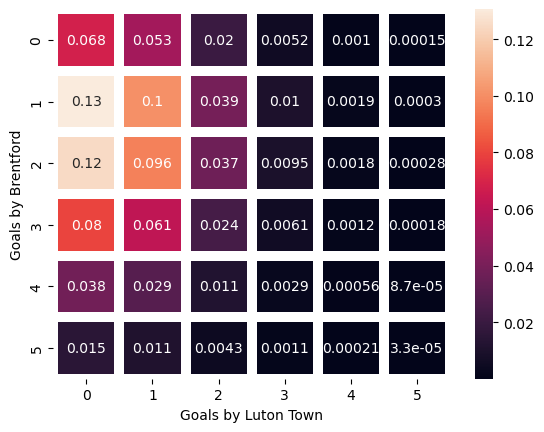

In [72]:
ax=sns.heatmap(score_matrix,linewidths=7,annot=True)
ax.set_xlabel('Goals by ' +  str(awayTeam))
ax.set_ylabel('Goals by ' +  str(homeTeam))
plt.show()

The most likely scoreline between Brentford and Luton is 1-0 or 2-0 (with a combined 25%).

Home win,draw or away win probabilities and odds can be calculated as follows:

In [73]:
home_win=np.sum(np.tril(score_matrix,-1))
away_win=np.sum(np.triu(score_matrix,1))
draw=np.sum(np.diag(score_matrix))
print(homeTeam + ' win probability is ' + str(round(home_win*100,2)) + '%' )
print(awayTeam + ' win probability is ' + str(round(away_win*100,2)) + '%')
print('The probability of the two teams drawing the match is ' + str(round(draw*100,2)) + '%')

Brentford win probability is 63.01%
Luton Town win probability is 14.34%
The probability of the two teams drawing the match is 21.28%


As we can see in the latest bets provided by a bookmaker, The bookies have 21.97% chance of a draw while our model suggested more or less similar probability of a draw (21.28%).

Brentford has an 67.5% (1/1.48) chance of winning the game which is very close to the odds we get from the poisson model

The rest of the project is building a web app to predict footballl match results. The web app is deployed on streamlit.